# Emotion Dataset — EDA & Preprocessing Checks

This notebook inspects split sizes and class balance, validates image paths, and previews a few images.


In [12]:
import os
import pandas as pd 
import matplotlib.pyplot as plt

In [13]:
# Paths (adjust if your files live elsewhere)
CSV_TRAIN = "../data/processed/EmoSet_splits/train.csv"
CSV_VAL   = "../data/processed/EmoSet_splits/val.csv"
CSV_TEST  = "../data/processed/EmoSet_splits/test.csv"
LABEL_MAP_JSON = "../data/processed/EmoSet_splits/label_map.json"
STATS_JSON     = "../data/processed/EmoSet_splits/stats.json"   
assert os.path.exists(CSV_TRAIN), f"Missing {CSV_TRAIN}"
assert os.path.exists(CSV_VAL),   f"Missing {CSV_VAL}"
assert os.path.exists(CSV_TEST),  f"Missing {CSV_TEST}"

In [14]:
train_df = pd.read_csv(CSV_TRAIN)
val_df   = pd.read_csv(CSV_VAL)
test_df  = pd.read_csv(CSV_TEST)

In [15]:
display(train_df.head())
display(val_df.head())
display(test_df.head())

,filepath,label,label_id,split
0,train/angry/14147.jpg,angry,0,train
1,train/angry/24084.jpg,angry,0,train
2,train/angry/823.jpg,angry,0,train
3,train/angry/19463.jpg,angry,0,train
4,train/angry/30797.jpg,angry,0,train


,filepath,label,label_id,split
0,validation/angry/10336.jpg,angry,0,val
1,validation/angry/3913.jpg,angry,0,val
2,validation/angry/23780.jpg,angry,0,val
3,validation/angry/22807.jpg,angry,0,val
4,validation/angry/34359.jpg,angry,0,val


,filepath,label,label_id,split
0,validation/angry/18949.jpg,angry,0,test
1,validation/angry/23404.jpg,angry,0,test
2,validation/angry/34448.jpg,angry,0,test
3,validation/angry/8593.jpg,angry,0,test
4,validation/angry/842.jpg,angry,0,test


## Split sizes


In [16]:
sizes = {
    "train": len(train_df),
    "val":   len(val_df),
    "test":  len(test_df),
}
sizes

{'train': 28385, 'val': 5564, 'test': 1391}

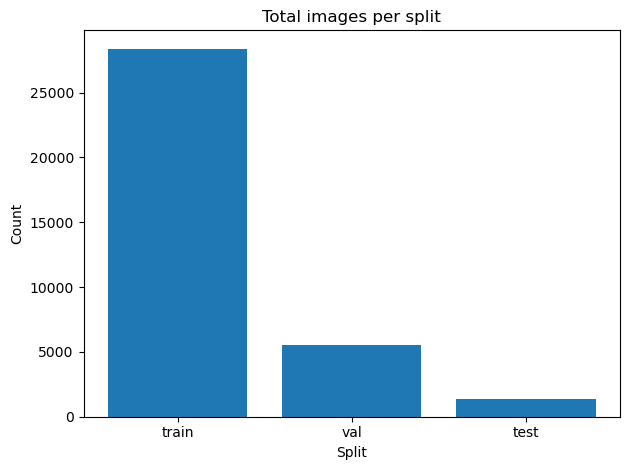

In [17]:
# Bar: total per split (matplotlib only, one figure per chart, no styles/colors set)
plt.figure()
plt.bar(list(sizes.keys()), list(sizes.values()))
plt.title("Total images per split")
plt.xlabel("Split")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


## Class distribution per split


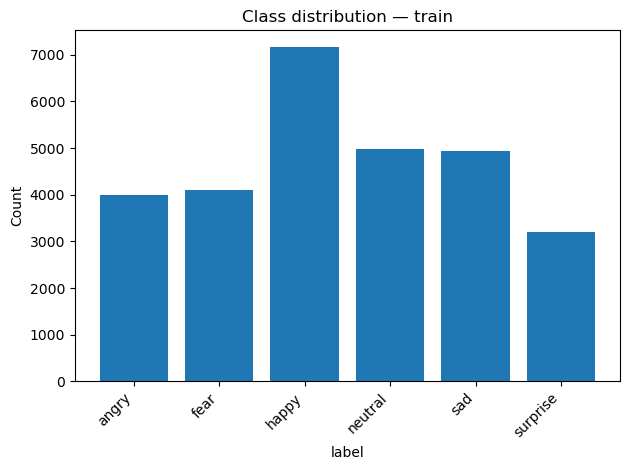

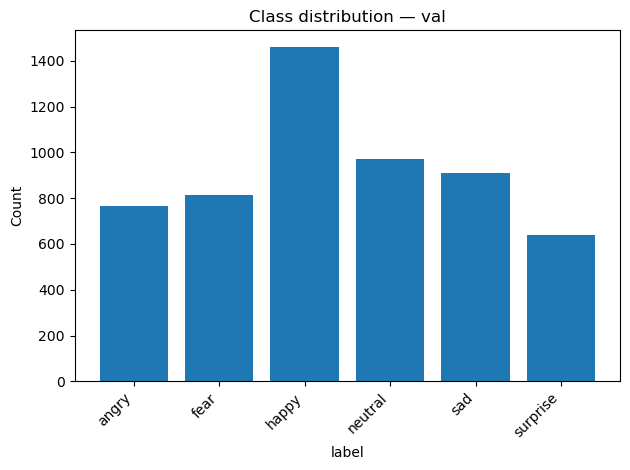

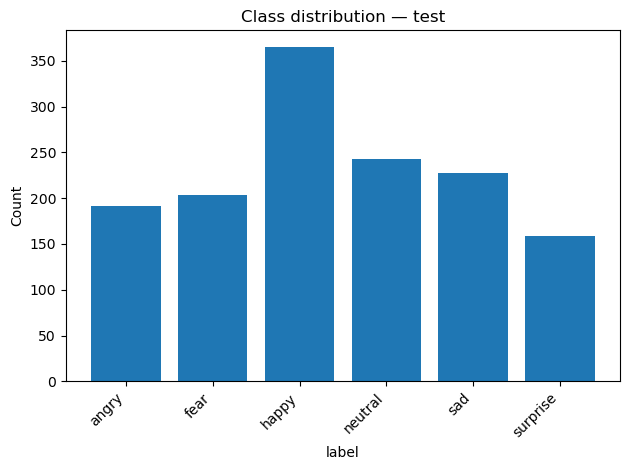

In [18]:
def plot_class_dist(df, split_name):
    vc = df['label'].value_counts().sort_index()
    plt.figure()
    plt.bar(vc.index.tolist(), vc.values.tolist())
    plt.title(f"Class distribution — {split_name}")
    plt.xlabel("label")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

plot_class_dist(train_df, "train")
plot_class_dist(val_df, "val")
plot_class_dist(test_df, "test")


In [19]:
# Statistic analysis
import json

with open(STATS_JSON) as f:
    stats = json.load(f)

# Build dataframe from stats.json
rows = []
for split, info in stats["splits"].items():
    for lab, cnt in info["by_label"].items():
        rows.append({"split": split, "label": lab, "count": cnt})

df = pd.DataFrame(rows)

In [20]:
# Overall counts
global_counts = df.groupby("label")["count"].sum().sort_values(ascending=False)
print("Total per class:\n", global_counts)

Total per class:
 label
happy       8989
neutral     6198
sad         6077
fear        5121
angry       4953
surprise    4002
Name: count, dtype: int64


In [21]:
# Percentages
total = global_counts.sum()
print("\nPercentage per class:")
print((global_counts / total * 100).round(2))


Percentage per class:
label
happy       25.44
neutral     17.54
sad         17.20
fear        14.49
angry       14.02
surprise    11.32
Name: count, dtype: float64


In [22]:
# Summary stats
print("\nDescriptive statistics:")
print(global_counts.describe())


Descriptive statistics:
count       6.000000
mean     5890.000000
std      1718.575457
min      4002.000000
25%      4995.000000
50%      5599.000000
75%      6167.750000
max      8989.000000
Name: count, dtype: float64
